# Assignment 1

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import numba
%matplotlib inline

##  standard Python function

In [2]:
def diffusion_iteration(un,f):

    N = un.shape[0] - 2
    result = np.zeros((N + 2, N + 2), dtype=np.float64)
    
    for i in range(1, N + 1):
        for j in range(1, N + 1):
            result[i, j] = (f[i,j]+un[i + 1, j] + un[i - 1, j] + un[i, j + 1] + un[i, j - 1]) / 4
    
    return result

##  Numba accelerated function

In [3]:
@numba.njit
def diffusion_iteration_numba(un,f):
    
    N = un.shape[0] - 2
    result = np.zeros((N + 2, N + 2), dtype=np.float64)
    
    for i in range(1, N + 1):
        for j in range(1, N + 1):
            result[i, j] = (f[i,j]+un[i + 1, j] + un[i - 1, j] + un[i, j + 1] + un[i, j - 1]) / 4
    
    return result

## parallel Numba

In [4]:
@numba.njit(['float64[:,:](float64[:,:],float64[:,:])'],parallel=True)
def diffusion_iteration_numba_p(un,f):
    
    N = un.shape[0] - 2
    result = np.zeros((N + 2, N + 2), dtype=np.float64)
    
    for i in numba.prange(1, N + 1):
        for j in range(1, N + 1):
            result[i, j] = (f[i,j]+un[i + 1, j] + un[i - 1, j] + un[i, j + 1] + un[i, j - 1]) / 4
    
    return result

## benchmark function

In [5]:
def benchmark(nvals,func):
    """Benchmark the diffusion iteration."""
    
    times = []
    
    for N in nvals:
        u = np.random.randn(N + 2, N + 2)
        f = np.random.randn(N + 2, N + 2)
        if func=='py':
            t = %timeit -o diffusion_iteration(u,f)
        elif func=='numba':
            t = %timeit -o diffusion_iteration_numba(u,f)
        elif func=='p':
            t = %timeit -o diffusion_iteration_numba_p(u,f)
        times.append(t.average)

    plt.figure()
    plt.plot(nvals, times, 'r-x', markersize=2)
    plt.xlabel('N')
    plt.ylabel('time [s]')

## benchmark of standard python

167 µs ± 8.54 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
624 µs ± 21.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.41 ms ± 50.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.43 ms ± 52.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.84 ms ± 32.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.51 ms ± 64.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.66 ms ± 221 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.87 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.5 ms ± 258 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.5 ms ± 96.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


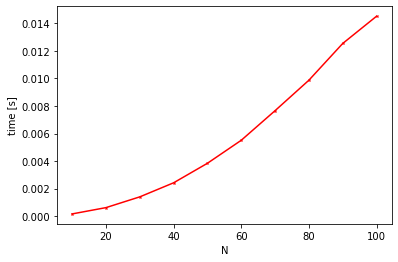

In [7]:
N = 100
nsteps = 200

u = np.zeros((N + 2, N + 2), dtype='float64')
f = np.ones((N + 2, N + 2), dtype='float64')
u[:, 0] = u[:, N + 1] = u[0, :] = 1

for i in range(nsteps):
    u = diffusion_iteration(u,f)

nvals = range(10, 101, 10)
benchmark(nvals,'py')

## benchmark of numba version

In [8]:
nvals=[100, 1000, 5000, 10000]

7.84 µs ± 122 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
3.6 ms ± 314 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
81.4 ms ± 1.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
389 ms ± 38.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


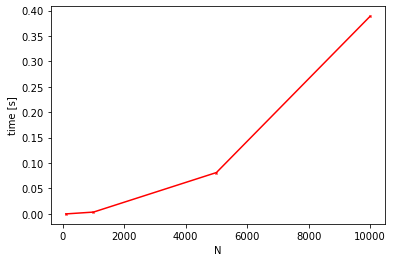

In [9]:
benchmark(nvals,'numba')

### we can see when n=100 the numba version(7.84 µs) is much faster than the standard python(14.5 ms).

## benchmark of parallel version

50.7 µs ± 3.68 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2.81 ms ± 40 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
77 ms ± 3.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
284 ms ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


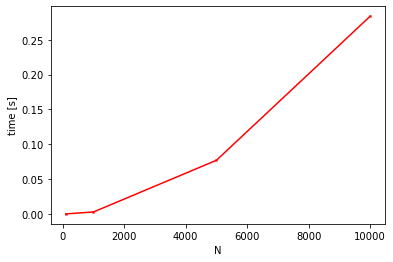

In [10]:
benchmark(nvals,'p')

In [11]:
import os
os.cpu_count()

16

### we can see that for N=100 the parallel version is slower than the normal numba version, because the parallelisation has overhead. If there is not enough work to do then this overhead will slow everything down. And as N increases, the parallel version performs better than the Numba version, but it is only 1.5 times faster when N=10000. Theoretically, the improvement can be 16 times faster because my laptop has 16 cores. One reason is that the computation is actually held back by memory accesses and less by actual compute performance.

## Convergence

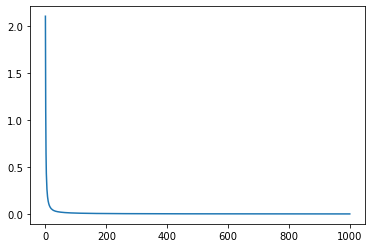

In [38]:
N=100
un = np.random.randn(N + 2, N + 2)
f = np.ones((N + 2, N + 2), dtype='float64')
error=[]
for i in range(1000):
    un_=un.copy()
    un=diffusion_iteration_numba_p(un,f)
    rel_error = np.linalg.norm(un_ - un, np.inf) / np.linalg.norm(un, np.inf)
    error.append(rel_error)

un1=un.copy()
plt.plot(error)

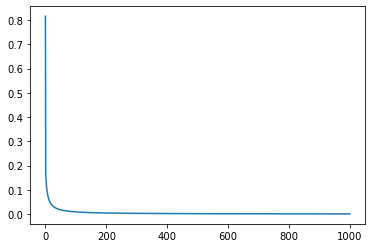

In [39]:
un = np.ones((N + 2, N + 2), dtype='float64')
f = np.ones((N + 2, N + 2), dtype='float64')
error=[]
for i in range(1000):
    un_=un.copy()
    un=diffusion_iteration_numba_p(un,f)
    rel_error = np.linalg.norm(un_ - un, np.inf) / np.linalg.norm(un, np.inf)
    error.append(rel_error)

un2=un.copy()
plt.plot(error)

In [40]:
np.linalg.norm(un1 - un2, np.inf) / np.linalg.norm(un2, np.inf)

0.0032153473500485053

### we can see different start configurations lead to convergence, and the convergence results tend to be the same.

# Assignment 2

In [1]:
import numpy as np
import numba
from numba import cuda
import math

In [2]:
SX=16
SY=16
ntargets = 50

In [3]:
rand = np.random.RandomState(0)
targets = rand.rand(ntargets,2)
weights = rand.rand(ntargets)

## cpu version

In [4]:
@numba.njit(parallel=True)
def evaluation_cpu(targets, weights, result):
    """Evaluate the RBF sum."""
    m = len(targets)
    result[:] = 0
    for index in numba.prange(m):
        
        result[index] = np.sum(np.where(np.sum(np.abs(targets[index] - targets), axis=1)!=0,np.log(np.sum(np.abs(targets[index] - targets), axis=1)),0) * weights)
    
    return result

In [5]:
result_cpu = np.empty(ntargets, dtype=np.float64)
evaluation_cpu(targets, weights, result_cpu)

array([-22.0077865 , -24.51184006, -22.96309229, -14.88161397,
       -11.80159518, -17.65907083, -16.33363341,  -8.74111897,
        -6.27547334, -11.07209073,  -8.03853981, -19.45024285,
       -13.63236787,  -6.57334485, -23.43196026, -15.92928766,
       -23.25328965, -10.01736775, -22.67577456, -11.56482082,
       -22.34975388, -16.39751706, -20.26004412, -16.05304731,
       -21.74223097, -23.96239619,  -8.28324292, -17.36458005,
       -19.69854841, -21.746818  , -13.35758247, -19.1137826 ,
       -17.58533569, -15.41727678, -13.64807858, -11.25923816,
       -11.59110168, -14.2958261 , -18.61327976, -19.72073822,
       -21.24495603, -11.51522826, -22.01429348, -18.16059993,
       -15.09698615, -20.1873833 , -14.17585314, -18.11891403,
       -15.50199255,  -9.54113495])

## gpu version

### our kernel threadblocks is of size 16 x 16. Each threadblock evaluates its own local result, which is an array of size 16 and writes the result back into global memory. then create a second kernel that runs over the intermediate results and sums up the intermediate results into the final sum.

In [6]:
@cuda.jit
def evaluation_cuda(targets, weights, tmp):
    local_result = cuda.shared.array((SX, SY), numba.float32)
    local_targets = cuda.shared.array((SX, 2), numba.float32)
    local_sources = cuda.shared.array((SY, 2), numba.float32)
    local_weights = cuda.shared.array(SY, numba.float32)
    
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    by = cuda.blockIdx.y
    px,py= cuda.grid(2)
    
    if px >= targets.shape[0]:
        return

    
    if ty == 0:
        for index in range(2):
            local_targets[tx, index] = targets[px, index]
        
    
    if tx == 0:
        for index in range(2):
            local_sources[ty, index] = targets[py, index]
        local_weights[ty] = weights[py]
        
    
    cuda.syncthreads()
    
    
    squared_diff = numba.float32(0)

    for index in range(2):
  
        squared_diff += abs(local_targets[tx, index] - local_sources[ty, index])
    if squared_diff==numba.float32(0):
        local_result[tx, ty]=0
    else:
        local_result[tx, ty] = math.log(squared_diff)* local_weights[ty]
    
    cuda.syncthreads()
    
    if ty == 0:
        res = numba.float32(0)
        for index in range(SY):
            res += local_result[tx, index]
        tmp[px, by] = res


@cuda.jit
def sum_kernel(tmp, result, nblocks):
    """This kernel sums up all intermediate results."""
    
    px = cuda.grid(1)
    
    if px >= result.shape[0]:
        return
    
    local_result = numba.float32(0)
    for index in range(nblocks):
        local_result += tmp[px, index]
    result[px] = local_result

In [7]:
result_gpu = np.empty(ntargets, dtype=np.float32)
def implement(targets,weights,result):
    nblocks = (targets.shape[0] + SX - 1) // SX
    targets_cuda = cuda.to_device(targets.astype('float32'))
    weights_cuda = cuda.to_device(weights.astype('float32'))
    tmp = cuda.device_array((ntargets, nblocks), dtype=np.float32)
    result_gpu_ = cuda.device_array(targets.shape[0], dtype=np.float32)
    evaluation_cuda[(nblocks, nblocks), (SX, SY)](targets_cuda, weights_cuda, tmp)
    sum_kernel[(ntargets + 15) // 16, 16](tmp, result_gpu_, nblocks)
    result_gpu_.copy_to_host(result)
implement(targets,weights,result_gpu)

## validation

In [8]:
rel_error = np.linalg.norm(result_cpu - result_gpu) / np.linalg.norm(result_cpu)
print(rel_error)

7.12186304175228e-08


### the result shows that the cuda kernel returns the same result as the python version.

## benchmark

In [10]:
def benchmark(n):
    """Benchmark with n sources and n targets."""
 
    targets = rand.rand(n, 2)
    weights = rand.rand(n)
    ntargets=n
    result_cpu = np.empty(n, dtype=np.float64)
    result_gpu = np.empty(n, dtype=np.float32)
    nblocks = (targets.shape[0] + SX - 1) // SX
    print("CPU Timing:")
    %timeit evaluation_cpu(targets, weights, result_cpu)
    
    print("GPU Timing:")
    %timeit implement(targets,weights,result_gpu)
    
    print("Validation")
    rel_error = np.linalg.norm(result_cpu - result_gpu, np.inf) / np.linalg.norm(result_cpu, np.inf)
    print(rel_error)

print("Timing for dimension n = 100")
print("----------------------------")
benchmark(100)
print("Timing for dimension n = 10000")
print("-----------------------------")
benchmark(10000)

Timing for dimension n = 100
----------------------------
CPU Timing:
185 µs ± 10.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
GPU Timing:
1.29 ms ± 4.03 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Validation
1.186147216975131e-07
Timing for dimension n = 10000
-----------------------------
CPU Timing:
205 ms ± 5.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GPU Timing:
8.36 ms ± 32.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Validation
1.069779833122388e-06


### For small sizes the CPU is faster than GPU because setting cuda kernels has overhead, and this will spend more time when the computation is cheap. For larger sizes the GPU timing significantly outperforms the CPU timing.

# Assignment 3

In [38]:
import numpy as np
import numba
from numba import cuda
from scipy.sparse.linalg import LinearOperator
from scipy.sparse import random
from matplotlib import pyplot as plt

In [31]:
class csr_matrix_cuda(LinearOperator):


    def __init__(self, data, indices, indptr, shape):

        self._data = data
        self._indices = indices
        self._indptr = indptr
        self.shape = shape
        self.dtype = data.dtype

    def _matvec(self, vec):

        vec=cuda.to_device(vec.astype('float32'))
        
        res=cuda.device_array(self.shape[0], dtype=np.float32)
        cud[(A.shape[0]+31)//32,32](vec, self._data ,self._indices,self._indptr, self.shape[0],res)
        res_ = np.empty(self.shape[0], dtype=np.float32)
        res.copy_to_host(res_)
        return res

@cuda.jit
def cud(vec, data, indices, indptr, nrows,res):

    px= cuda.grid(1)

    if px>=nrows:
        return
    tmp=numba.float32(0)
    for index in range(indptr[px], indptr[px + 1]):
        col_index = indices[index]
        tmp += data[index] * vec[col_index]
    res[px]=tmp

## Validation

### we use the discretise_poisson result to validate our results.

In [14]:
from scipy.sparse import coo_matrix

def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16
    
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    f = np.empty(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = 0
                count += 1
                
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                f[j * N + i] = 1
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f

In [15]:
N = 2000
A, _ = discretise_poisson(N)
rand = np.random.RandomState(0)
x = rand.randn(N * N)

In [33]:
A_data=cuda.to_device(A.data.astype('float32'))
A_ind=cuda.to_device(A.indices.astype('int64'))
A_ptr=cuda.to_device(A.indptr.astype('int64'))
test=csr_matrix_cuda(A_data,A_ind,A_ptr,A.shape)

In [34]:
print('cuda:')
%timeit res_=test._matvec(x)
print('standard:')
%timeit y=A@x
res_=test._matvec(x)
y=A@x
rel_error = np.linalg.norm(res_ - y, np.inf) / np.linalg.norm(y, np.inf)
print(f"Error: {rel_error}")

cuda:
20.4 ms ± 1.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
standard:
26.4 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Error: 1.3245489616228246e-07


### we can see that our implementation is faster than the standard multiplication, and the result is the same.

## benchmark

In [35]:
dens=[0.2,0.4,0.6,0.8]
N_=[100,1000,10000]

matrix size: 100
density:0.2
standard matrix multiplication:
6.1 µs ± 150 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
cuda matrix multiplication:
705 µs ± 7.51 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
density:0.4
standard matrix multiplication:
7.58 µs ± 132 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
cuda matrix multiplication:
712 µs ± 10.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
density:0.6
standard matrix multiplication:
9.36 µs ± 79.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
cuda matrix multiplication:
716 µs ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
density:0.8
standard matrix multiplication:
11.5 µs ± 110 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
cuda matrix multiplication:
718 µs ± 7.48 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


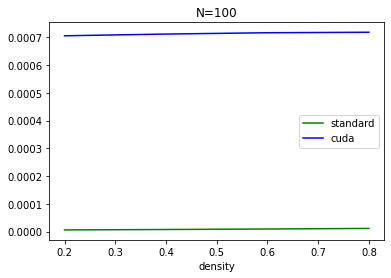

matrix size: 1000
density:0.2
standard matrix multiplication:
180 µs ± 3.81 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
cuda matrix multiplication:
725 µs ± 4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
density:0.4
standard matrix multiplication:
362 µs ± 1.83 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
cuda matrix multiplication:
791 µs ± 5.63 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
density:0.6
standard matrix multiplication:
562 µs ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
cuda matrix multiplication:
827 µs ± 2.61 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
density:0.8
standard matrix multiplication:
751 µs ± 5.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
cuda matrix multiplication:
870 µs ± 6.45 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


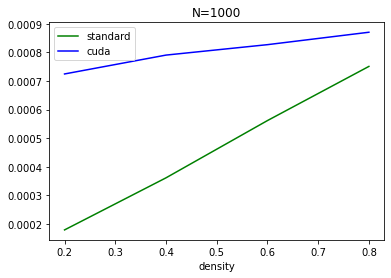

matrix size: 10000
density:0.2
standard matrix multiplication:
21.7 ms ± 215 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
cuda matrix multiplication:
3.95 ms ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
density:0.4
standard matrix multiplication:
43.5 ms ± 975 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
cuda matrix multiplication:
8.07 ms ± 167 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
density:0.6
standard matrix multiplication:
64.8 ms ± 585 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
cuda matrix multiplication:
12.1 ms ± 379 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
density:0.8
standard matrix multiplication:
86.5 ms ± 765 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
cuda matrix multiplication:
16.4 ms ± 378 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


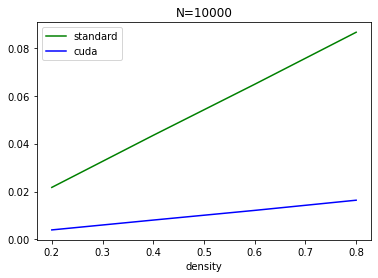

In [40]:
for N in N_: 
    print(f'matrix size: {N}')
    t1=[]
    t2=[]
    for density in dens:
        S=random(N,N,density=density)
        A=coo_matrix(S.A).tocsr()
        x=np.ones(N)
        print(f'density:{density:.1f}')
        print('standard matrix multiplication:')
        t_1= %timeit -o A@x
        print('cuda matrix multiplication:')
        A_data=cuda.to_device(A.data.astype('float32'))
        A_ind=cuda.to_device(A.indices.astype('int64'))
        A_ptr=cuda.to_device(A.indptr.astype('int64'))
        test=csr_matrix_cuda(A_data,A_ind,A_ptr,A.shape)
        t_2=%timeit -o test._matvec(x)
        t1.append(t_1.average)
        t2.append(t_2.average)
    plt.plot(dens,t1,color='g',label='standard')
    plt.plot(dens,t2,color='b',label='cuda')
    plt.title(f'N={N}')
    plt.xlabel('density')
    plt.legend()
    plt.show()
    

### we can see that for small N, the cuda implementation is slower because of its overhead. For large N, the cuda implementation is much faster than the standard multiplication. The computation time increases as the density increases, which is also expected.

# Assignment 4

In [43]:
import numpy as np
import numba
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs, LinearOperator, cg, bicgstab, gmres, spsolve
from scipy.linalg import solve
import time

In [92]:
true_value = 0.424011387033

We have to solve the equation:  

$ \frac{\partial f}{\partial t} =  \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} $

In this case, our boundary conditions are: 

at $t<0$, $f(x, y, t) = 0$, 

for $t \geq 0$, $f(-1, y, t) = f(x, \pm 1, t) = 0$.

 

We are looking at the time $t^*$, where $f(0, 0, t^*) = 1$ is the most precise result.


## explicit time-stepping

### forward Euler

In [100]:
@numba.njit
def forward_matrix(N, dx, dt):
    row = []
    col = []
    data = []   
    
    for i in np.arange(N**2):
        if (i%N==0) or (i%N==N-1) or (i//N==0) or (i//N==N-1): 
            row.append(i)
            col.append(i)
            data.append(1)
        else:
            row.append(i)
            col.append(i)
            data.append(-4*dt/(dx*dx)+1)

            row.append(i)
            col.append(i-1)
            data.append(dt/(dx*dx))

            row.append(i)
            col.append(i+1)
            data.append(dt/(dx*dx))

            row.append(i)
            col.append(i-N)
            data.append(dt/(dx*dx))

            row.append(i)
            col.append(i+N)
            data.append(dt/(dx*dx))       
    return np.float64(data), row, col

def forward_euler(N,dt):
    dx = np.float64(2/(N-1))
    val = 0
    iters = 0
    data,row,col=forward_matrix(N, dx, dt)
    A = sparse.coo_matrix((data,(row,col)), shape=(N**2, N**2), dtype = np.float64).tocsr()
    grid = np.zeros((N,N), dtype = np.float64)
    grid[:,N-1] = np.ones(N)*5
    grid_ = np.zeros(N**2)
    grid_[:N] = 5
    
    while grid_[(N*N)//2] < 1:
        val += dt
        iters += 1
        grid_ = A.dot(grid_)

    return val, val - true_value, iters

## benchmark

In [101]:
testN = [9, 17, 31, 51, 91]
dt = 1e-5
errors = []

for N in testN:
    res = forward_euler(N, dt)
    errors.append(res[1])

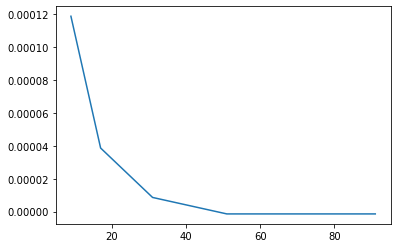

In [102]:
plt.plot(testN,errors)

In [103]:
res[0]

0.42401000000028327

### we get 5 digits correct here

## impliclit time-stepping

### backward Euler

In [105]:
@numba.njit
def backward_matrix(N, dx, dt):

    row = []
    col = []
    data = []   
    
    for i in np.arange(N**2):
        if (i%N==0) or (i%N==N-1) or (i//N==0) or (i//N==N-1): 
            row.append(i)
            col.append(i)
            data.append(1)

        else:
            row.append(i)
            col.append(i)
            data.append(4*dt/(dx*dx) + 1)
            
            row.append(i)
            col.append(i-1)
            data.append(-dt/(dx*dx))
 
            row.append(i)
            col.append(i+1)
            data.append(-dt/(dx*dx))

            row.append(i)
            col.append(i-N)
            data.append(-dt/(dx*dx))
   
            row.append(i)
            col.append(i+N)
            data.append(-dt/(dx*dx))
            
    return np.float64(data), row, col

In [106]:
def backward_euler(N,dt):
    dx = np.float64(2/(N-1))
    val = 0
    iters = 0
    data,row,col=backward_matrix(N, dx, dt)
    A = sparse.coo_matrix((data,(row,col)), shape=(N**2, N**2), dtype = np.float64).tocsr()
    grid = np.zeros((N,N), dtype = np.float64)
    grid[:,N-1] = np.ones(N)*5
    grid_ = np.zeros(N**2)
    grid_[:N] = 5
    
    while grid_[(N*N)//2] < 1:
        val += dt
        iters += 1
        grid_=spsolve(A, grid_)

    return val, val - true_value, iters

## benchmark

In [ ]:
errors = []
for N in testN:
    res = backward_euler(N, dt)
    errors.append(res[1])

In [ ]:
plt.plot(testN,errors)

In [60]:
res[0]

(0.4240300000002833, 1.8612967283282433e-05, 42403)